In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, datediff, to_date, avg, count
import json
import matplotlib.pyplot as plt
import numpy as np

spark = SparkSession.builder \
    .appName("MySparkApp") \
    .getOrCreate()


25/03/29 19:49:04 WARN Utils: Your hostname, ana resolves to a loopback address: 127.0.1.1; using 192.168.110.240 instead (on interface wlo1)
25/03/29 19:49:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/29 19:49:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/03/29 19:49:07 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [1]:
from pyspark.sql.functions import explode

# cargamos los jsons de las categorias con multiline = true ya que los jsons tienen más de una línea
data_set_categories_MX = spark.read.option("multiline", "true").json("hdfs://localhost:9000/user/hadoop/ana/datasets/MX_category_id.json")
data_set_categories_BR = spark.read.option("multiline", "true").json("hdfs://localhost:9000/user/hadoop/ana/datasets/BR_category_id.json")
data_set_categories_US = spark.read.option("multiline", "true").json("hdfs://localhost:9000/user/hadoop/ana/datasets/US_category_id.json")

# Veamos el esquema de uno de los dataframes
data_set_categories_MX.printSchema()

# Ahora queremos nada mas las columnas id y title, que es la información que nos interesa

# Las columnas id y title están en formato de array, debemos aplanarlas para que sean valores individuales
data_set_categories_MX = data_set_categories_MX.select(explode(col("items")).alias("item")) \
	.select(col("item.id").alias("category_id"), col("item.snippet.title").alias("category_name"))
data_set_categories_BR = data_set_categories_BR.select(explode(col("items")).alias("item")) \
	.select(col("item.id").alias("category_id"), col("item.snippet.title").alias("category_name"))
data_set_categories_US = data_set_categories_US.select(explode(col("items")).alias("item")) \
	.select(col("item.id").alias("category_id"), col("item.snippet.title").alias("category_name"))

# Ahora queremos ver los primeros 5 registros de cada dataframe
data_set_categories_MX.show(5)
data_set_categories_BR.show(5)
data_set_categories_US.show(5)

NameError: name 'spark' is not defined

In [3]:
# cargamos el dataset modificado de MX
data_set_MX = spark.read.csv("hdfs://localhost:9000/user/hadoop/ana/datasets/MX.csv", header=True)
# contar el numero de registros
print("Numero de registros en MX: ", data_set_MX.count())
# Vemos el esquema del dataframe
data_set_MX.printSchema()

Numero de registros en MX:  268598
root
 |-- video_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- publishedAt: string (nullable = true)
 |-- channelId: string (nullable = true)
 |-- channelTitle: string (nullable = true)
 |-- categoryId: string (nullable = true)
 |-- trending_date: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- view_count: string (nullable = true)
 |-- likes: string (nullable = true)
 |-- dislikes: string (nullable = true)
 |-- comment_count: string (nullable = true)
 |-- thumbnail_link: string (nullable = true)
 |-- comments_disabled: string (nullable = true)
 |-- ratings_disabled: string (nullable = true)



In [4]:
# cargamos el dataset modificado de BR
data_set_BR = spark.read.csv("hdfs://localhost:9000/user/hadoop/ana/datasets/BR.csv", header=True)
# contar el numero de registros
print("Numero de registros en BR: ", data_set_BR.count())
# Vemos el esquema del dataframe
data_set_BR.printSchema()

Numero de registros en BR:  268790
root
 |-- video_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- publishedAt: string (nullable = true)
 |-- channelId: string (nullable = true)
 |-- channelTitle: string (nullable = true)
 |-- categoryId: string (nullable = true)
 |-- trending_date: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- view_count: string (nullable = true)
 |-- likes: string (nullable = true)
 |-- dislikes: string (nullable = true)
 |-- comment_count: string (nullable = true)
 |-- thumbnail_link: string (nullable = true)
 |-- comments_disabled: string (nullable = true)
 |-- ratings_disabled: string (nullable = true)



In [5]:
# cargamos el dataset modificado de US
data_set_US = spark.read.csv("hdfs://localhost:9000/user/hadoop/ana/datasets/US.csv", header=True)
# contar el numero de registros
print("Numero de registros en US: ", data_set_US.count())
# Vemos el esquema del dataframe
data_set_US.printSchema()

Numero de registros en US:  268787
root
 |-- video_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- publishedAt: string (nullable = true)
 |-- channelId: string (nullable = true)
 |-- channelTitle: string (nullable = true)
 |-- categoryId: string (nullable = true)
 |-- trending_date: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- view_count: string (nullable = true)
 |-- likes: string (nullable = true)
 |-- dislikes: string (nullable = true)
 |-- comment_count: string (nullable = true)
 |-- thumbnail_link: string (nullable = true)
 |-- comments_disabled: string (nullable = true)
 |-- ratings_disabled: string (nullable = true)



In [21]:
# MEXICO
# Crear una nueva columna con la diferencia de días entre trending_date y publishedAt
data_set_with_diff_MX = data_set_MX.withColumn(
    "diff_days", datediff(to_date(col("trending_date")), to_date(col("publishedAt")))
)

# Agrupar por categoryId y comments_disabled, y calcular las métricas solicitadas
resultMX = data_set_with_diff_MX.groupBy("categoryId", "comments_disabled").agg(
    count("video_id").alias("number_videos"),
    avg("diff_days").alias("promedio_diff_dias_a_tendencia"),
    avg("view_count").alias("promedio_views"),
    avg("likes").alias("promedio_likes"),
    avg("dislikes").alias("promedio_dislikes"),
    avg("comment_count").alias("promedio_comments")
)

# Mostrar el resultado con el nombre de la categoría
resultMX = resultMX.join(data_set_categories_MX, resultMX.categoryId == data_set_categories_MX.category_id).select(
    "categoryId", "category_name",
    "comments_disabled", "number_videos", "promedio_diff_dias_a_tendencia", "promedio_views",
    "promedio_likes", "promedio_dislikes", "promedio_comments"
).orderBy(col("categoryId").cast("int"), col("comments_disabled"))

print("Resultado del dataset de México:\n")
resultMX.show(truncate=False, n=100)


Resultado del dataset de México:



+----------+--------------------+-----------------+-------------+------------------------------+-------------------+------------------+------------------+------------------+
|categoryId|category_name       |comments_disabled|number_videos|promedio_diff_dias_a_tendencia|promedio_views     |promedio_likes    |promedio_dislikes |promedio_comments |
+----------+--------------------+-----------------+-------------+------------------------------+-------------------+------------------+------------------+------------------+
|1         |Film & Animation    |FALSE            |7156         |6.055058692006708             |2194907.8596981554 |85295.59013415316 |355.0445779765232 |4975.9670206819455|
|1         |Film & Animation    |TRUE             |73           |6.054794520547945             |5065399.767123288  |8496.753424657534 |23.602739726027398|0.0               |
|2         |Autos & Vehicles    |FALSE            |2488         |5.616961414790997             |783176.182073955   |52957.28979099

In [22]:
# BRASIL
# Crear una nueva columna con la diferencia de días entre trending_date y publishedAt
data_set_with_diff_BR = data_set_BR.withColumn(
    "diff_days", datediff(to_date(col("trending_date")), to_date(col("publishedAt")))
)

# Agrupar por categoryId y comments_disabled, y calcular las métricas solicitadas
resultBR = data_set_with_diff_BR.groupBy("categoryId", "comments_disabled").agg(
    count("video_id").alias("number_videos"),
    avg("diff_days").alias("promedio_diff_dias_a_tendencia"),
    avg("view_count").alias("promedio_views"),
    avg("likes").alias("promedio_likes"),
    avg("dislikes").alias("promedio_dislikes"),
    avg("comment_count").alias("promedio_comments")
).orderBy("categoryId")

# Mostrar el resultado con el nombre de la categoría
resultBR = resultBR.join(data_set_categories_BR, resultBR.categoryId == data_set_categories_BR.category_id).select(
    "categoryId", "category_name",
    "comments_disabled", "number_videos", "promedio_diff_dias_a_tendencia", "promedio_views",
    "promedio_likes", "promedio_dislikes", "promedio_comments"
).orderBy(col("categoryId").cast("int"), col("comments_disabled"))

print("Resultado del dataset de Brasil:\n")
resultBR.show(truncate=False, n=100)


Resultado del dataset de Brasil:



+----------+--------------------+-----------------+-------------+------------------------------+--------------------+------------------+------------------+------------------+
|categoryId|category_name       |comments_disabled|number_videos|promedio_diff_dias_a_tendencia|promedio_views      |promedio_likes    |promedio_dislikes |promedio_comments |
+----------+--------------------+-----------------+-------------+------------------------------+--------------------+------------------+------------------+------------------+
|1         |Film & Animation    |FALSE            |3297         |5.092205034880194             |1990123.1067637247  |78551.4440400364  |374.0400363967243 |4939.723688201395 |
|1         |Film & Animation    |TRUE             |32           |5.125                         |3607466.96875       |0.0               |0.0               |0.0               |
|2         |Autos & Vehicles    |FALSE            |2596         |5.13020030816641              |385032.18644067796  |28030.95

In [23]:
# ESTADOS UNIDOS
# Crear una nueva columna con la diferencia de días entre trending_date y publishedAt
data_set_with_diff_US = data_set_US.withColumn(
    "diff_days", datediff(to_date(col("trending_date")), to_date(col("publishedAt")))
)

# Agrupar por categoryId y comments_disabled, y calcular las métricas solicitadas
resultUS = data_set_with_diff_US.groupBy("categoryId", "comments_disabled").agg(
    count("video_id").alias("number_videos"),
    avg("diff_days").alias("promedio_diff_dias_a_tendencia"),
    avg("view_count").alias("promedio_views"),
    avg("likes").alias("promedio_likes"),
    avg("dislikes").alias("promedio_dislikes"),
    avg("comment_count").alias("promedio_comments")
).orderBy("categoryId")

# Mostrar el resultado con el nombre de la categoría
resultUS = resultUS.join(data_set_categories_US, resultUS.categoryId == data_set_categories_US.category_id).select(
    "categoryId", "category_name",
    "comments_disabled", "number_videos", "promedio_diff_dias_a_tendencia", "promedio_views",
    "promedio_likes", "promedio_dislikes", "promedio_comments"
).orderBy(col("categoryId").cast("int"), col("comments_disabled"))

print("Resultado del dataset de Estados Unidos:\n")
resultUS.show(truncate=False, n=100)


Resultado del dataset de Estados Unidos:



+----------+---------------------+-----------------+-------------+------------------------------+------------------+------------------+------------------+------------------+
|categoryId|category_name        |comments_disabled|number_videos|promedio_diff_dias_a_tendencia|promedio_views    |promedio_likes    |promedio_dislikes |promedio_comments |
+----------+---------------------+-----------------+-------------+------------------------------+------------------+------------------+------------------+------------------+
|1         |Film & Animation     |FALSE            |10811        |4.124132827675516             |2726762.7669040794|104367.77199149015|611.5130885209509 |7385.775968920544 |
|1         |Film & Animation     |TRUE             |112          |4.366071428571429             |3485320.0         |10253.99107142857 |674.7767857142857 |0.0               |
|2         |Autos & Vehicles     |FALSE            |5486         |3.892818082391542             |963175.2074371127 |43940.13853445

In [24]:
# Convertir los resultados a Pandas para poder graficar los resultados
resultMXPandas = resultMX.toPandas()
resultBRPandas = resultBR.toPandas()
resultUSPandas = resultUS.toPandas()

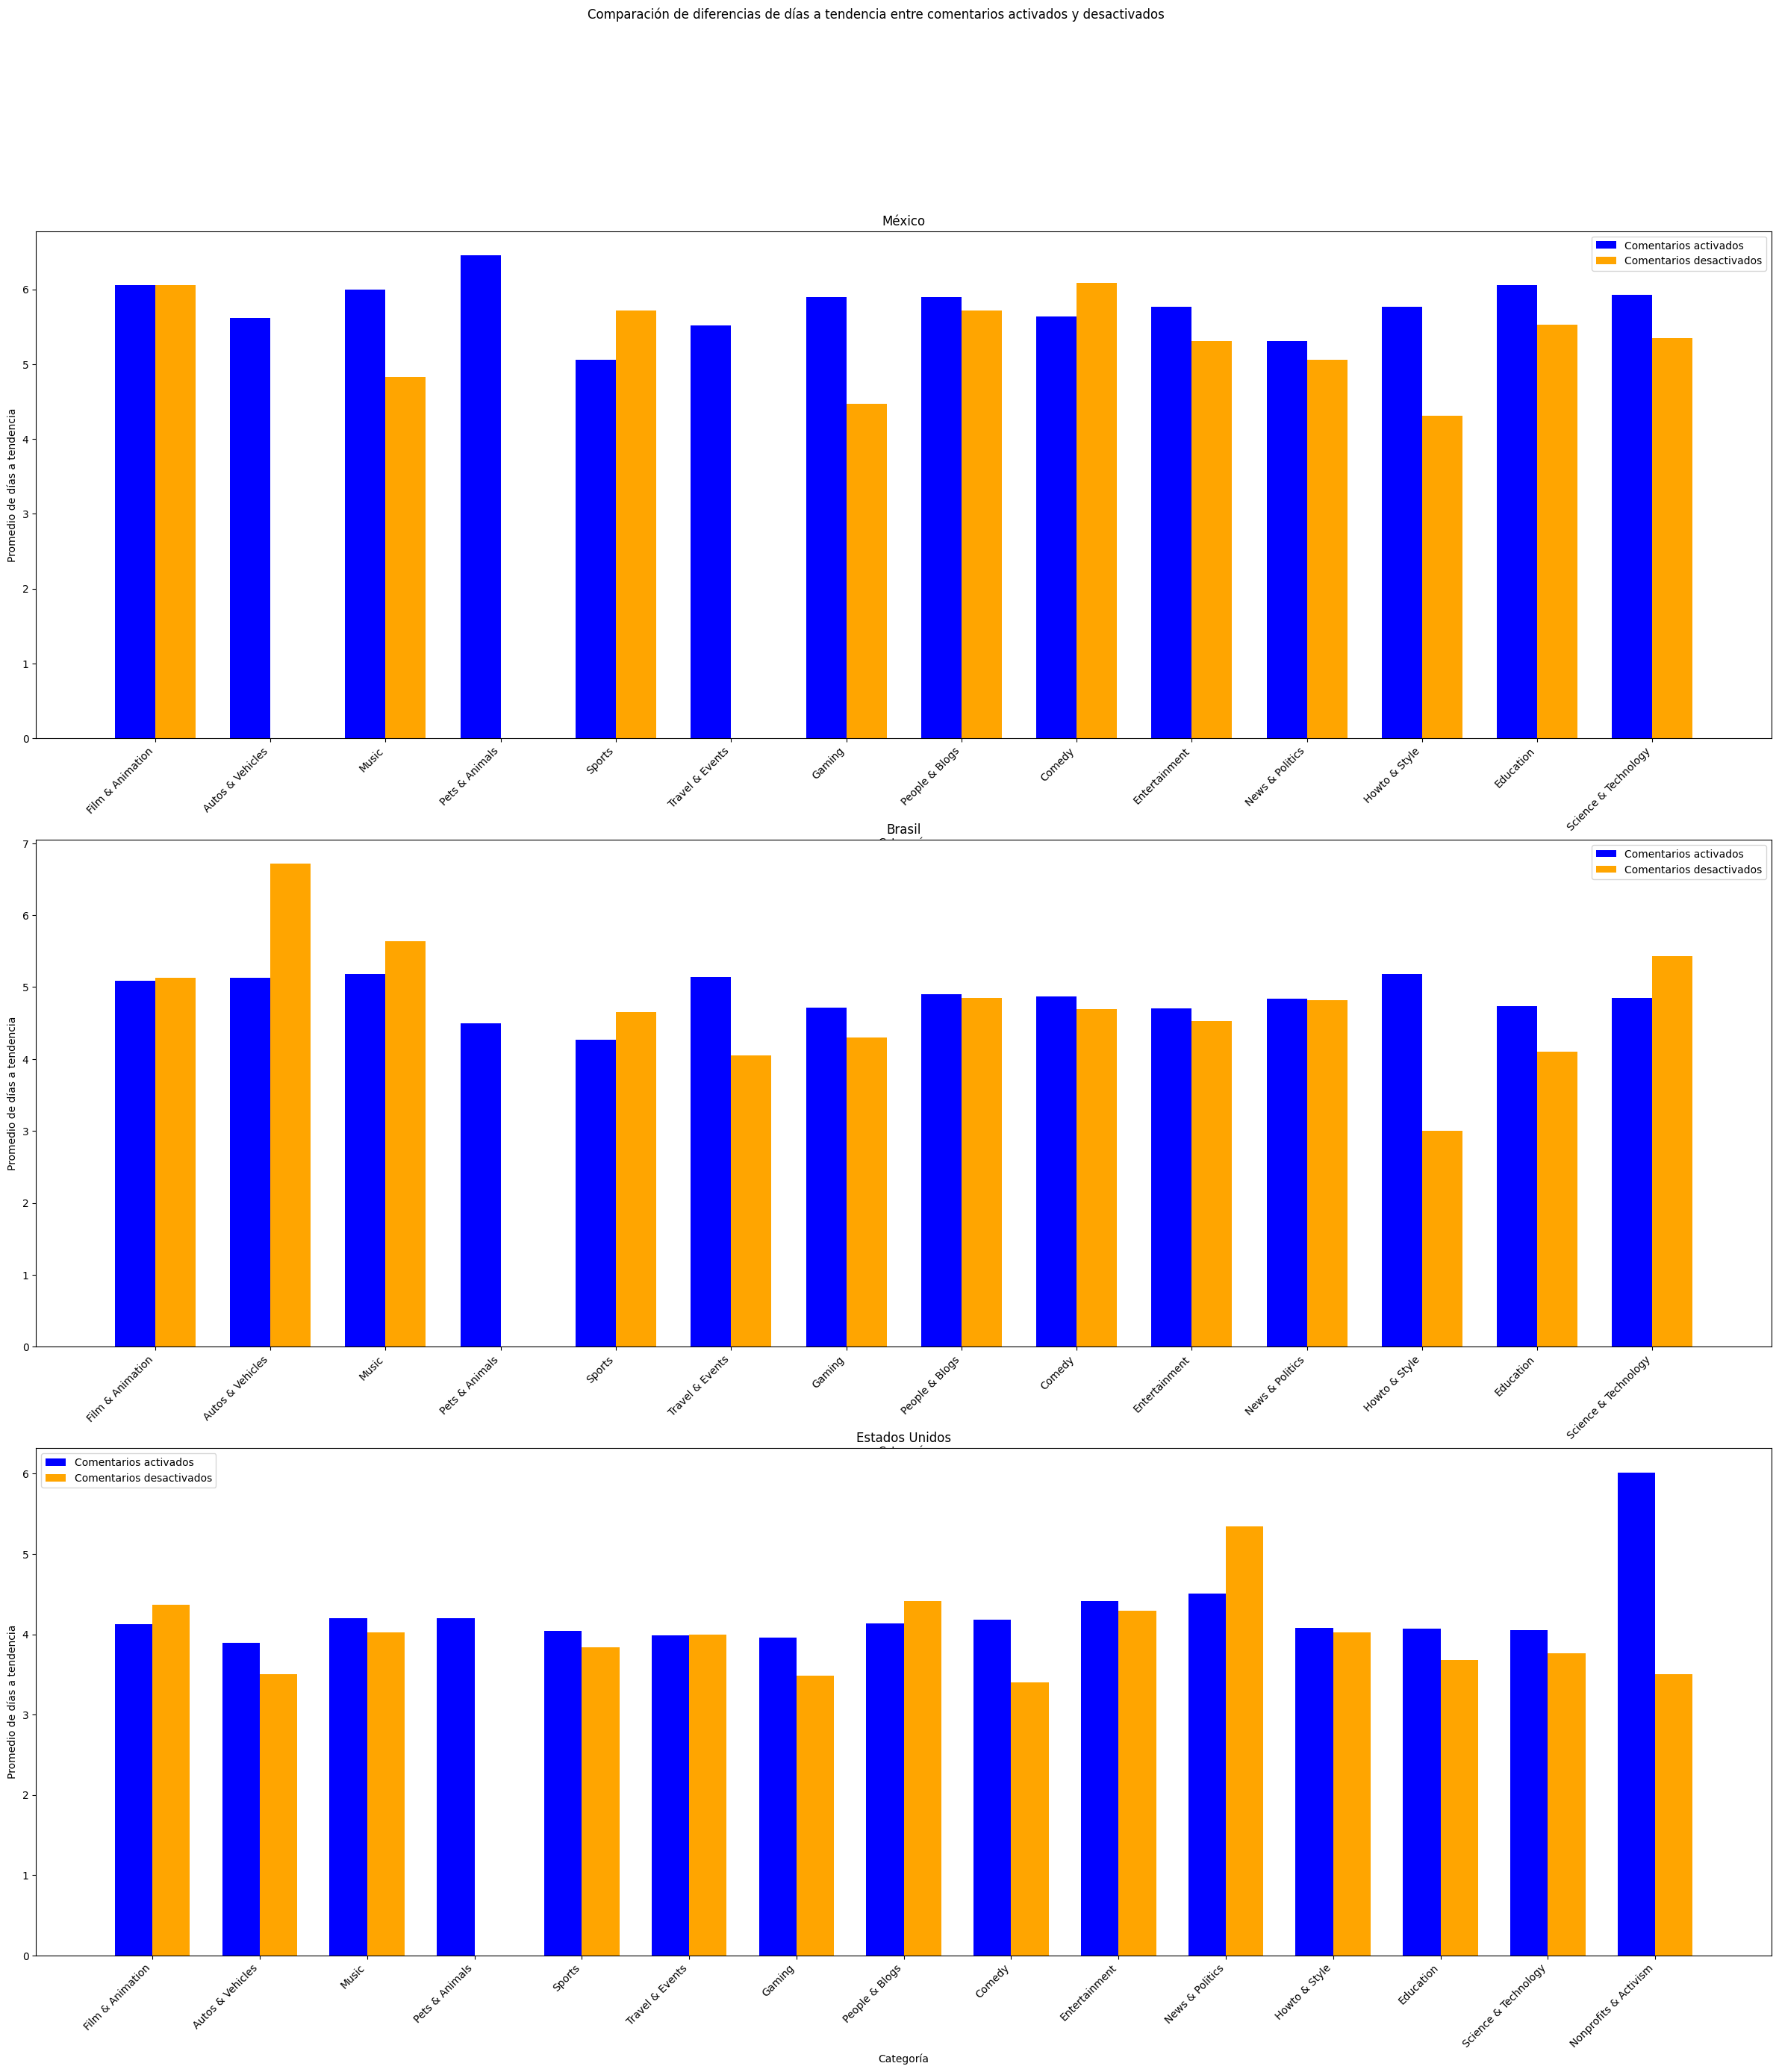

In [31]:
# comparacion de diferencias de días a tendencia entre comentarios activados y desactivados en MX, BR y US
fig, axs = plt.subplots(3, 1, figsize=(30, 30))
fig.suptitle("Comparación de diferencias de días a tendencia entre comentarios activados y desactivados")

# MX
resultMXCommentsEnabled = resultMXPandas[resultMXPandas["comments_disabled"] == "FALSE"]
resultMXCommentsDisabled = resultMXPandas[resultMXPandas["comments_disabled"] == "TRUE"]

categoriesMXAligned = resultMXPandas["category_name"].unique()
resultMXCommentsEnabledAligned = resultMXCommentsEnabled.set_index("category_name").reindex(categoriesMXAligned).reset_index()
resultMXCommentsDisabledAligned = resultMXCommentsDisabled.set_index("category_name").reindex(categoriesMXAligned).reset_index()

x = np.arange(len(categoriesMXAligned))
width = 0.35

axs[0].bar(x - width/2, resultMXCommentsEnabledAligned["promedio_diff_dias_a_tendencia"], width, color="blue", label="Comentarios activados")
axs[0].bar(x + width/2, resultMXCommentsDisabledAligned["promedio_diff_dias_a_tendencia"], width, color="orange", label="Comentarios desactivados")
axs[0].set_xticks(x)
axs[0].set_xticklabels(categoriesMXAligned, rotation=45, ha="right")
axs[0].set_title("México")
axs[0].set_ylabel("Promedio de días a tendencia")
axs[0].set_xlabel("Categoría")
axs[0].legend()

# BR
resultBRCommentsEnabled = resultBRPandas[resultBRPandas["comments_disabled"] == "FALSE"]
resultBRCommentsDisabled = resultBRPandas[resultBRPandas["comments_disabled"] == "TRUE"]

categoriesBRAligned = resultBRPandas["category_name"].unique()
resultBRCommentsEnabledAligned = resultBRCommentsEnabled.set_index("category_name").reindex(categoriesBRAligned).reset_index()
resultBRCommentsDisabledAligned = resultBRCommentsDisabled.set_index("category_name").reindex(categoriesBRAligned).reset_index()

x = np.arange(len(categoriesBRAligned))

axs[1].bar(x - width/2, resultBRCommentsEnabledAligned["promedio_diff_dias_a_tendencia"], width, color="blue", label="Comentarios activados")
axs[1].bar(x + width/2, resultBRCommentsDisabledAligned["promedio_diff_dias_a_tendencia"], width, color="orange", label="Comentarios desactivados")
axs[1].set_xticks(x)
axs[1].set_xticklabels(categoriesBRAligned, rotation=45, ha="right")
axs[1].set_title("Brasil")
axs[1].set_ylabel("Promedio de días a tendencia")
axs[1].set_xlabel("Categoría")
axs[1].legend()

# US
resultUSCommentsEnabled = resultUSPandas[resultUSPandas["comments_disabled"] == "FALSE"]
resultUSCommentsDisabled = resultUSPandas[resultUSPandas["comments_disabled"] == "TRUE"]

categoriesUSAligned = resultUSPandas["category_name"].unique()
resultUSCommentsEnabledAligned = resultUSCommentsEnabled.set_index("category_name").reindex(categoriesUSAligned).reset_index()
resultUSCommentsDisabledAligned = resultUSCommentsDisabled.set_index("category_name").reindex(categoriesUSAligned).reset_index()

x = np.arange(len(categoriesUSAligned))

axs[2].bar(x - width/2, resultUSCommentsEnabledAligned["promedio_diff_dias_a_tendencia"], width, color="blue", label="Comentarios activados")
axs[2].bar(x + width/2, resultUSCommentsDisabledAligned["promedio_diff_dias_a_tendencia"], width, color="orange", label="Comentarios desactivados")
axs[2].set_xticks(x)
axs[2].set_xticklabels(categoriesUSAligned, rotation=45, ha="right")
axs[2].set_title("Estados Unidos")
axs[2].set_ylabel("Promedio de días a tendencia")
axs[2].set_xlabel("Categoría")
axs[2].legend()

plt.show()


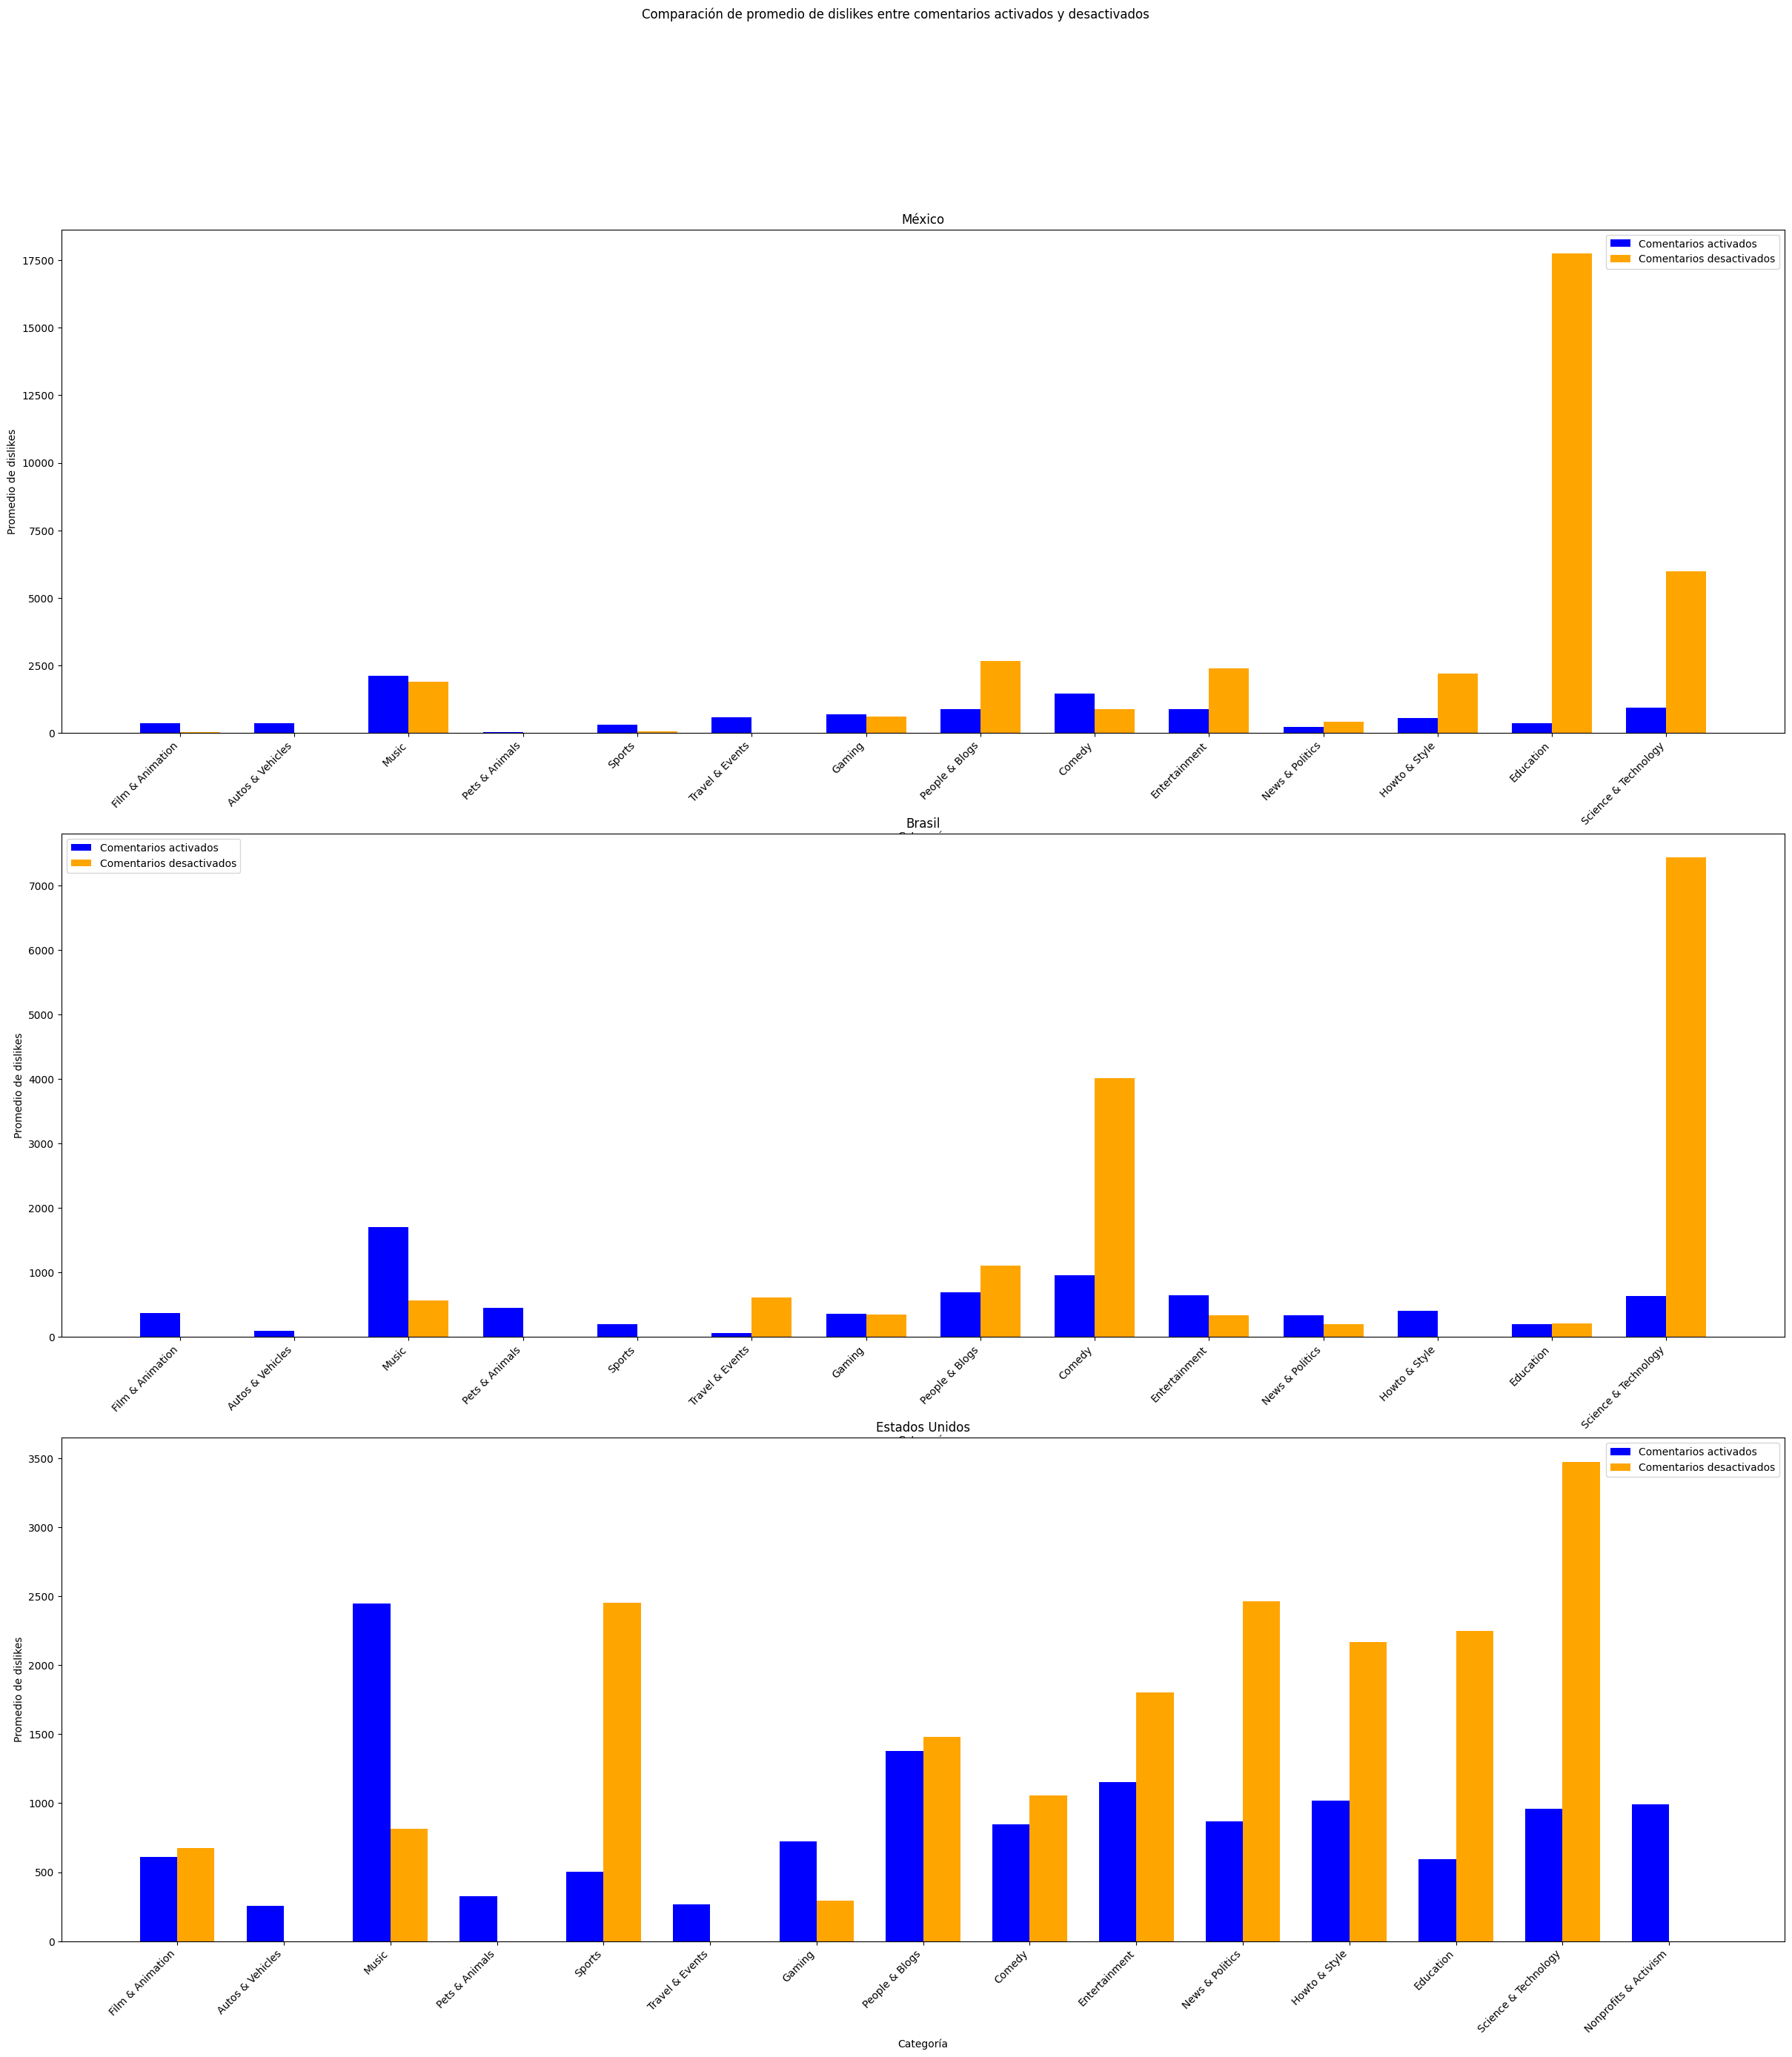

In [32]:
# Comparación de promedio de dislikes entre comentarios activados y desactivados en MX, BR y US
fig, axs = plt.subplots(3, 1, figsize=(30, 30))
fig.suptitle("Comparación de promedio de dislikes entre comentarios activados y desactivados")

# MX
x = np.arange(len(categoriesMXAligned))
axs[0].bar(x - width/2, resultMXCommentsEnabledAligned["promedio_dislikes"].fillna(0), width, color="blue", label="Comentarios activados")
axs[0].bar(x + width/2, resultMXCommentsDisabledAligned["promedio_dislikes"].fillna(0), width, color="orange", label="Comentarios desactivados")
axs[0].set_xticks(x)
axs[0].set_xticklabels(categoriesMXAligned, rotation=45, ha="right")
axs[0].set_title("México")
axs[0].set_ylabel("Promedio de dislikes")
axs[0].set_xlabel("Categoría")
axs[0].legend()

# BR
x = np.arange(len(categoriesBRAligned))
axs[1].bar(x - width/2, resultBRCommentsEnabledAligned["promedio_dislikes"].fillna(0), width, color="blue", label="Comentarios activados")
axs[1].bar(x + width/2, resultBRCommentsDisabledAligned["promedio_dislikes"].fillna(0), width, color="orange", label="Comentarios desactivados")
axs[1].set_xticks(x)
axs[1].set_xticklabels(categoriesBRAligned, rotation=45, ha="right")
axs[1].set_title("Brasil")
axs[1].set_ylabel("Promedio de dislikes")
axs[1].set_xlabel("Categoría")
axs[1].legend()

# US
x = np.arange(len(categoriesUSAligned))
axs[2].bar(x - width/2, resultUSCommentsEnabledAligned["promedio_dislikes"].fillna(0), width, color="blue", label="Comentarios activados")
axs[2].bar(x + width/2, resultUSCommentsDisabledAligned["promedio_dislikes"].fillna(0), width, color="orange", label="Comentarios desactivados")
axs[2].set_xticks(x)
axs[2].set_xticklabels(categoriesUSAligned, rotation=45, ha="right")
axs[2].set_title("Estados Unidos")
axs[2].set_ylabel("Promedio de dislikes")
axs[2].set_xlabel("Categoría")
axs[2].legend()

plt.show()


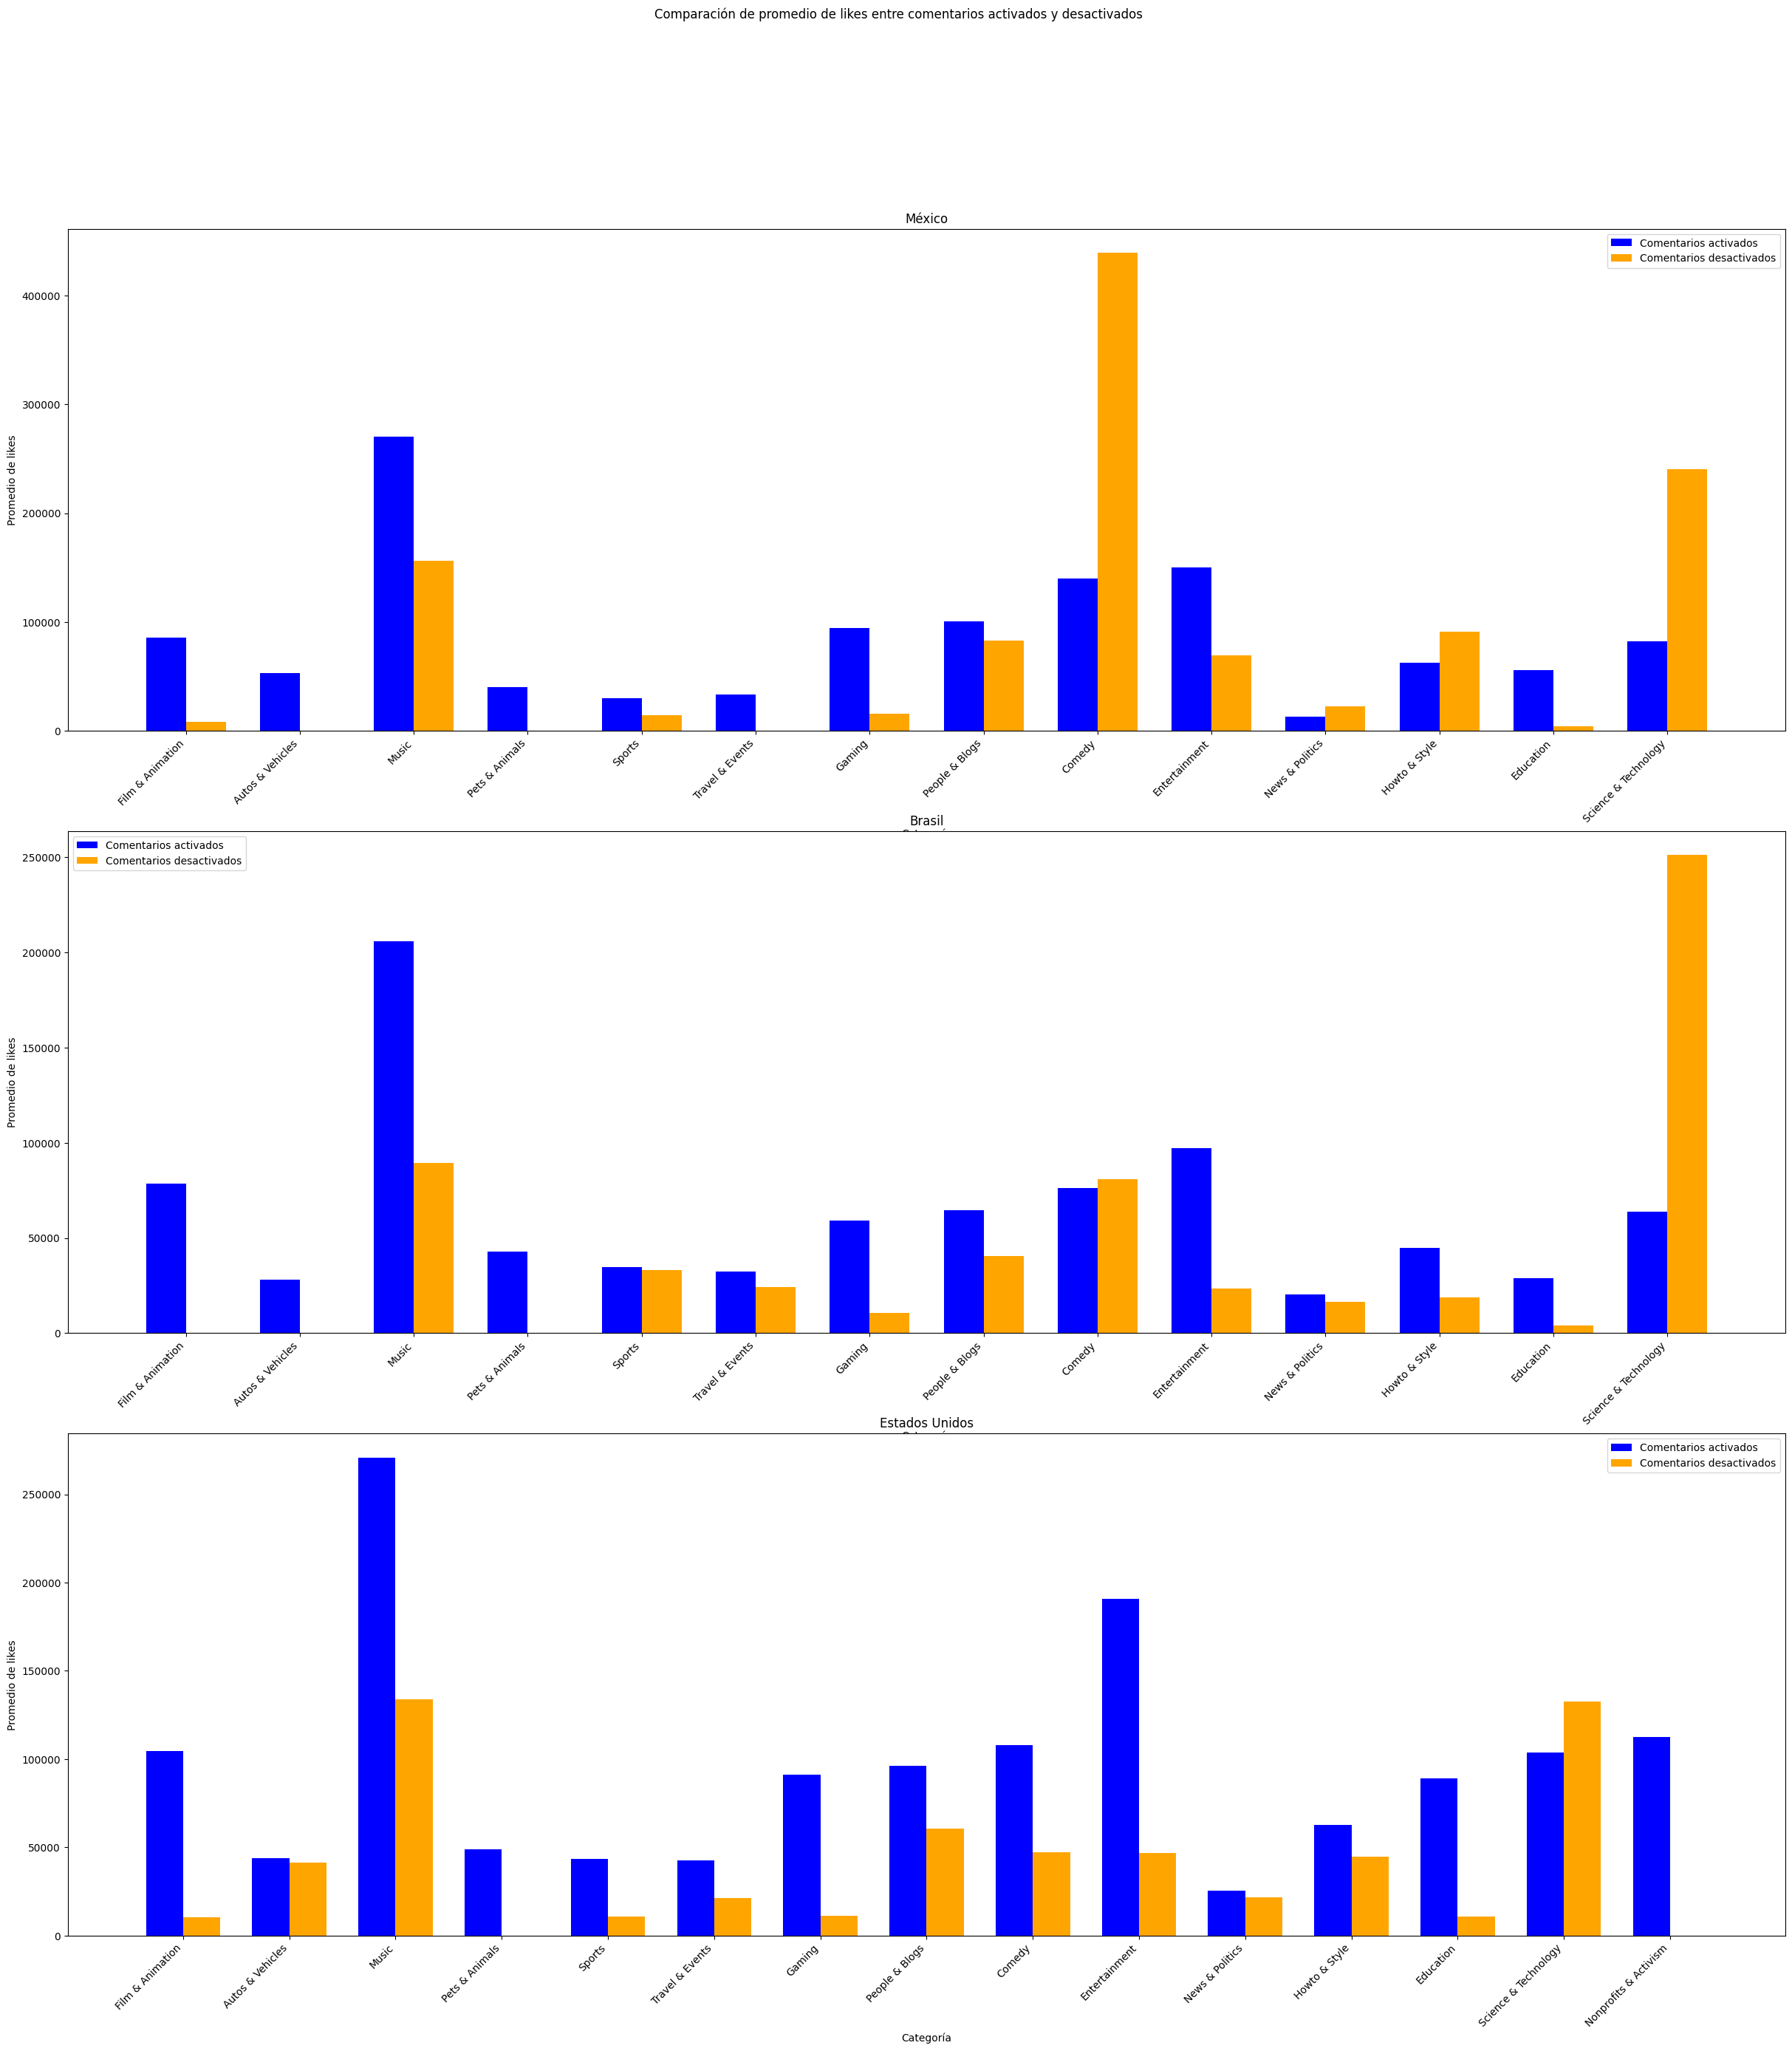

In [33]:
# Comparación de promedio de likes entre comentarios activados y desactivados en MX, BR y US
fig, axs = plt.subplots(3, 1, figsize=(30, 30))
fig.suptitle("Comparación de promedio de likes entre comentarios activados y desactivados")

# MX
x = np.arange(len(categoriesMXAligned))
axs[0].bar(x - width/2, resultMXCommentsEnabledAligned["promedio_likes"].fillna(0), width, color="blue", label="Comentarios activados")
axs[0].bar(x + width/2, resultMXCommentsDisabledAligned["promedio_likes"].fillna(0), width, color="orange", label="Comentarios desactivados")
axs[0].set_xticks(x)
axs[0].set_xticklabels(categoriesMXAligned, rotation=45, ha="right")
axs[0].set_title("México")
axs[0].set_ylabel("Promedio de likes")
axs[0].set_xlabel("Categoría")
axs[0].legend()

# BR
x = np.arange(len(categoriesBRAligned))
axs[1].bar(x - width/2, resultBRCommentsEnabledAligned["promedio_likes"].fillna(0), width, color="blue", label="Comentarios activados")
axs[1].bar(x + width/2, resultBRCommentsDisabledAligned["promedio_likes"].fillna(0), width, color="orange", label="Comentarios desactivados")
axs[1].set_xticks(x)
axs[1].set_xticklabels(categoriesBRAligned, rotation=45, ha="right")
axs[1].set_title("Brasil")
axs[1].set_ylabel("Promedio de likes")
axs[1].set_xlabel("Categoría")
axs[1].legend()

# US
x = np.arange(len(categoriesUSAligned))
axs[2].bar(x - width/2, resultUSCommentsEnabledAligned["promedio_likes"].fillna(0), width, color="blue", label="Comentarios activados")
axs[2].bar(x + width/2, resultUSCommentsDisabledAligned["promedio_likes"].fillna(0), width, color="orange", label="Comentarios desactivados")
axs[2].set_xticks(x)
axs[2].set_xticklabels(categoriesUSAligned, rotation=45, ha="right")
axs[2].set_title("Estados Unidos")
axs[2].set_ylabel("Promedio de likes")
axs[2].set_xlabel("Categoría")
axs[2].legend()

plt.show()


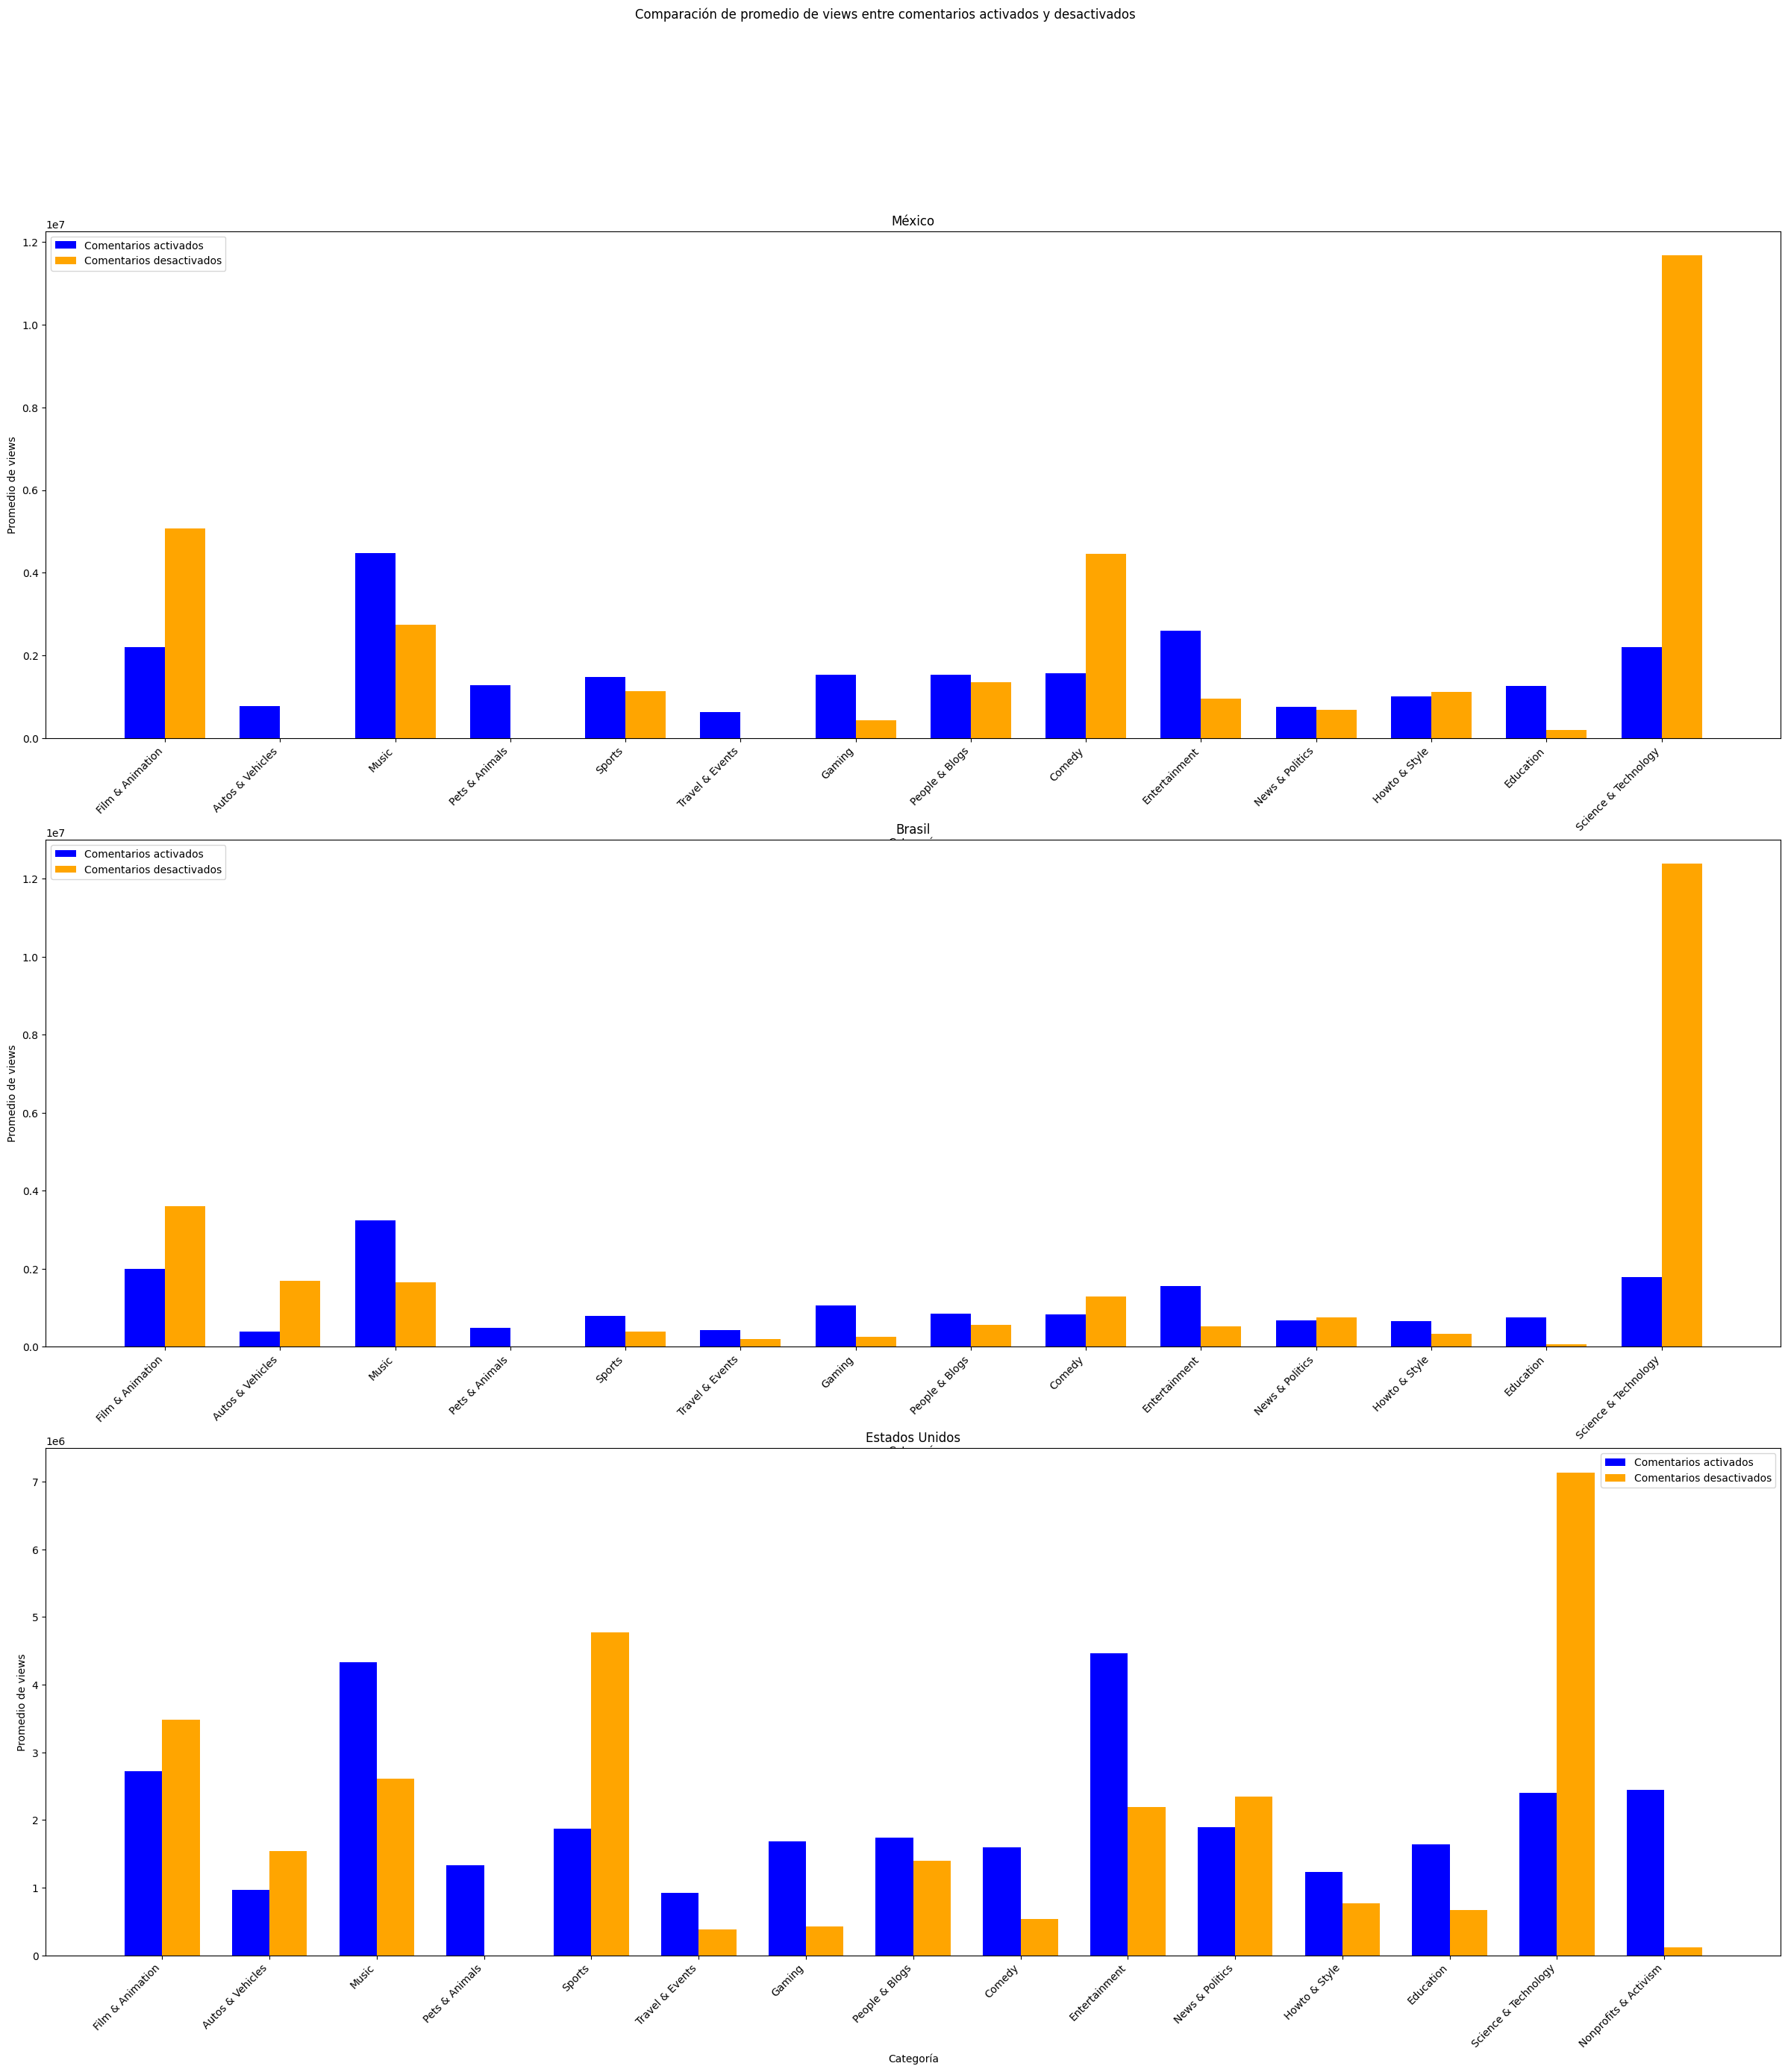

In [34]:
# Comparación de promedio de views entre comentarios activados y desactivados en MX, BR y US
fig, axs = plt.subplots(3, 1, figsize=(30, 30))
fig.suptitle("Comparación de promedio de views entre comentarios activados y desactivados")

# MX
x = np.arange(len(categoriesMXAligned))
axs[0].bar(x - width/2, resultMXCommentsEnabledAligned["promedio_views"].fillna(0), width, color="blue", label="Comentarios activados")
axs[0].bar(x + width/2, resultMXCommentsDisabledAligned["promedio_views"].fillna(0), width, color="orange", label="Comentarios desactivados")
axs[0].set_xticks(x)
axs[0].set_xticklabels(categoriesMXAligned, rotation=45, ha="right")
axs[0].set_title("México")
axs[0].set_ylabel("Promedio de views")
axs[0].set_xlabel("Categoría")
axs[0].legend()

# BR
x = np.arange(len(categoriesBRAligned))
axs[1].bar(x - width/2, resultBRCommentsEnabledAligned["promedio_views"].fillna(0), width, color="blue", label="Comentarios activados")
axs[1].bar(x + width/2, resultBRCommentsDisabledAligned["promedio_views"].fillna(0), width, color="orange", label="Comentarios desactivados")
axs[1].set_xticks(x)
axs[1].set_xticklabels(categoriesBRAligned, rotation=45, ha="right")
axs[1].set_title("Brasil")
axs[1].set_ylabel("Promedio de views")
axs[1].set_xlabel("Categoría")
axs[1].legend()

# US
x = np.arange(len(categoriesUSAligned))
axs[2].bar(x - width/2, resultUSCommentsEnabledAligned["promedio_views"].fillna(0), width, color="blue", label="Comentarios activados")
axs[2].bar(x + width/2, resultUSCommentsDisabledAligned["promedio_views"].fillna(0), width, color="orange", label="Comentarios desactivados")
axs[2].set_xticks(x)
axs[2].set_xticklabels(categoriesUSAligned, rotation=45, ha="right")
axs[2].set_title("Estados Unidos")
axs[2].set_ylabel("Promedio de views")
axs[2].set_xlabel("Categoría")
axs[2].legend()

plt.show()


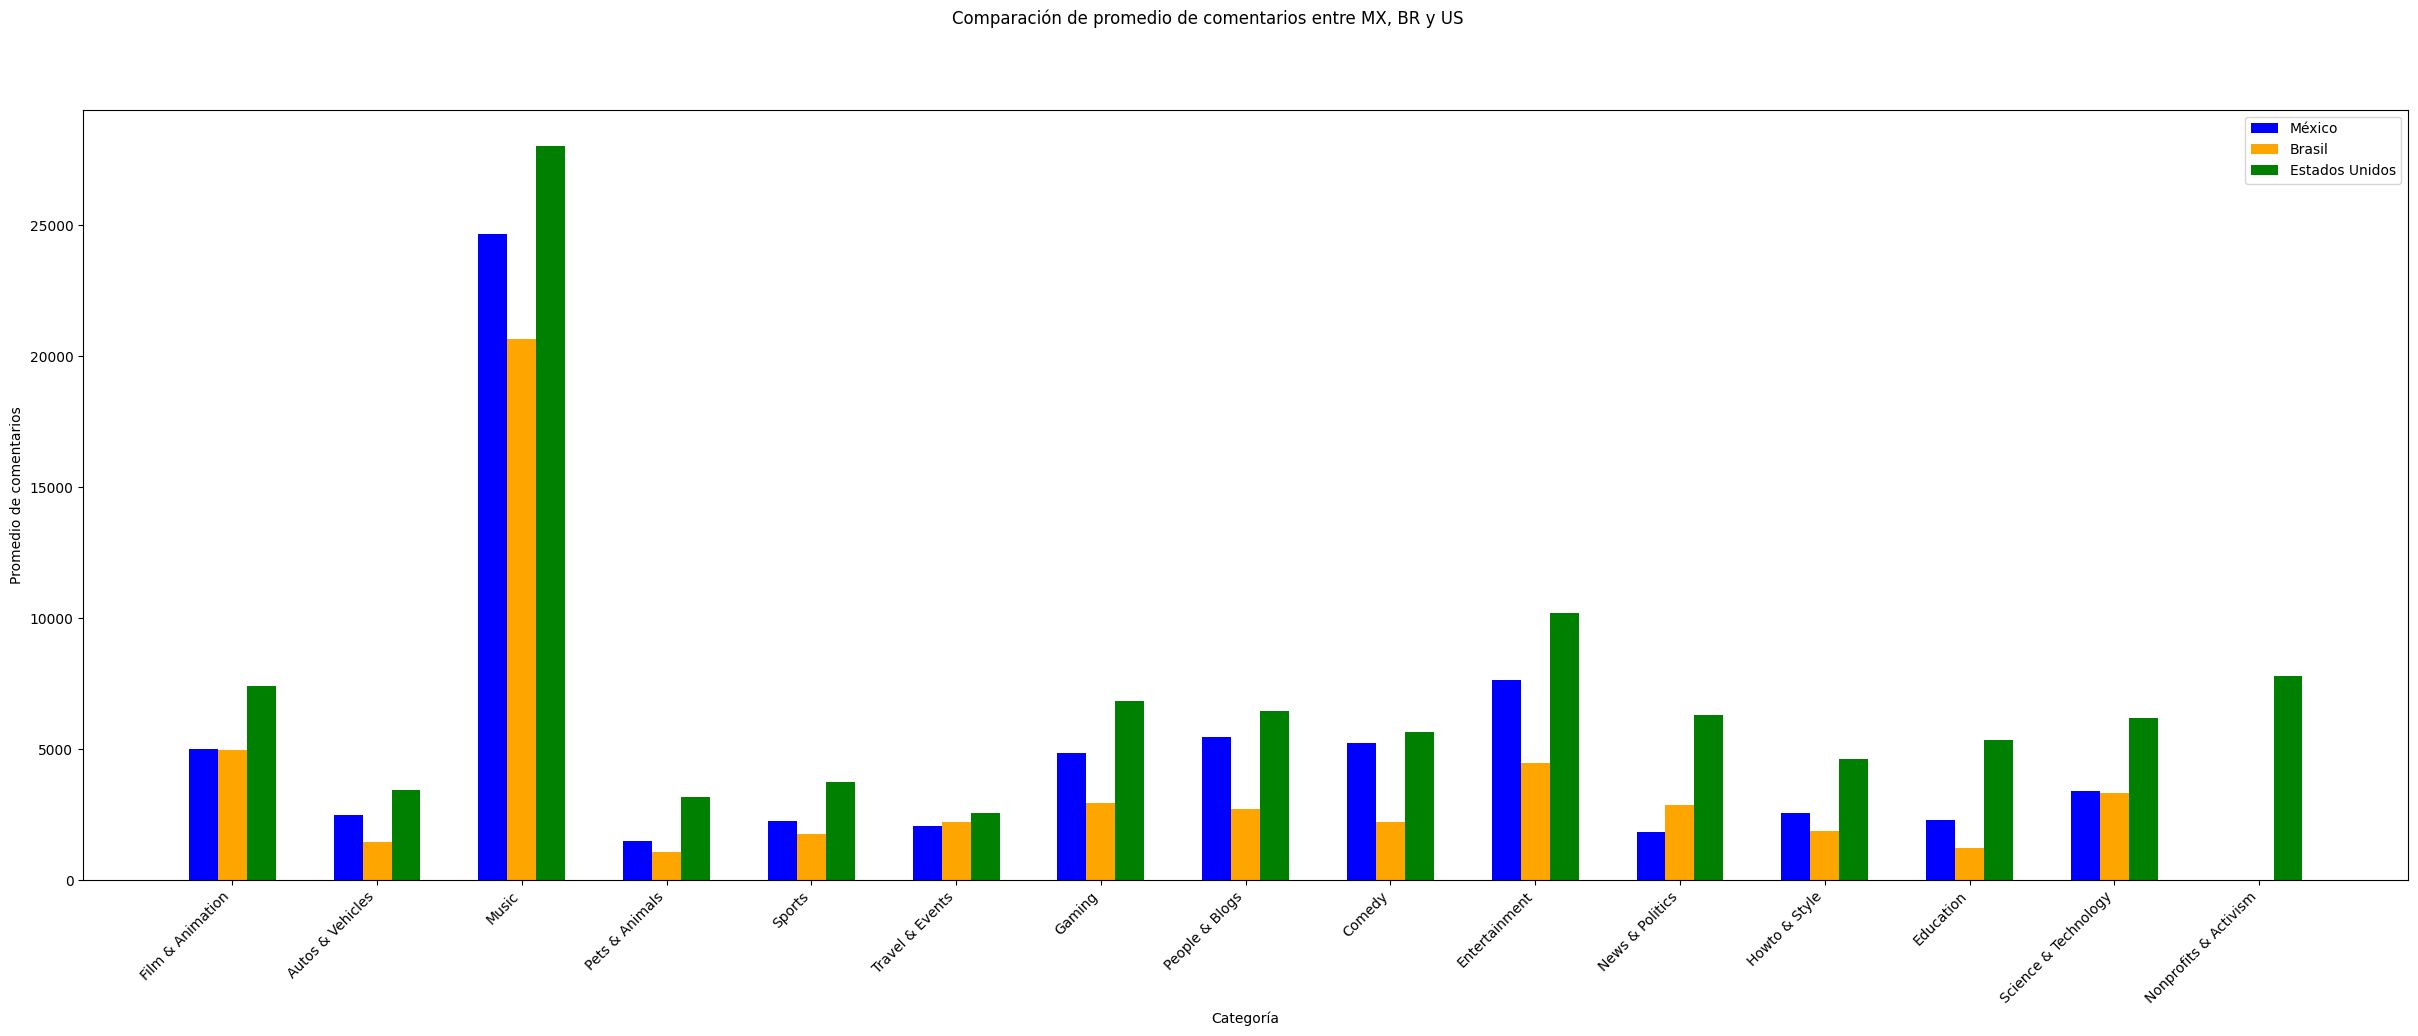

In [35]:
# Disminuir el ancho de las barras
width = 0.2

# Comparación de promedio de comentarios entre MX, BR y US
fig, axs = plt.subplots(1, 1, figsize=(30, 10))
fig.suptitle("Comparación de promedio de comentarios entre MX, BR y US")

categoriesMXAligned = resultMXCommentsEnabledAligned["category_name"]
categoriesBRAligned = resultBRCommentsEnabledAligned["category_name"]
categoriesUSAligned = resultUSCommentsEnabledAligned["category_name"]

xMX = np.arange(len(categoriesMXAligned))
xBR = np.arange(len(categoriesBRAligned))
xUS = np.arange(len(categoriesUSAligned))

axs.bar(xMX - width, resultMXCommentsEnabledAligned["promedio_comments"].fillna(0), width, color="blue", label="México")
axs.bar(xBR, resultBRCommentsEnabledAligned["promedio_comments"].fillna(0), width, color="orange", label="Brasil")
axs.bar(xUS + width, resultUSCommentsEnabledAligned["promedio_comments"].fillna(0), width, color="green", label="Estados Unidos")

axs.set_xticks(np.arange(max(len(categoriesMXAligned), len(categoriesBRAligned), len(categoriesUSAligned))))
axs.set_xticklabels(categoriesUSAligned, rotation=45, ha="right")
axs.set_ylabel("Promedio de comentarios")
axs.set_xlabel("Categoría")
axs.legend()

plt.show()
